# PINN 튜토리얼: 뉴턴 냉각법 예제 (Newton’s Law of Cooling)

이 노트북은 **Physics-Informed Neural Networks (PINNs)** 의 개념을 간단한 물리 시스템에 적용해보는 실습 예제입니다.  
예제로는 **뉴턴의 냉각 법칙 (Newtons Law of Cooling)** 을 사용합니다.

---

## 🎯 실험 목표
- 단순 신경망(NN)으로 **데이터만 학습했을 때의 한계**를 확인합니다.  
- 동일한 문제를 **PINN 구조**로 학습하여, 물리 방정식을 손실 함수에 통합했을 때 **일반화 성능 향상**을 확인합니다.

---

## 🧠 문제 설정

뉴턴의 냉각 법칙은 다음의 미분방정식으로 표현됩니다:

$$
\frac{dT}{dt} = -R\,\bigl(T - T_{\text{env}}\bigr)
$$

- \(T(t)\): 시간에 따른 물체의 온도  
- \(T_{\text{env}}\): 주변 환경 온도  
- \(R\): 냉각 비율 (Cooling rate)

해의 형태는 다음과 같습니다:

$$
T(t) = T_{\text{env}} + (T_0 - T_{\text{env}})\,e^{-R t}
$$

---

## 🔍 튜토리얼 구성

| 단계 | 내용 |
|------|------|
| **1️⃣ 데이터 생성** | 냉각 데이터를 시뮬레이션하여 일부 노이즈를 추가합니다. |
| **2️⃣ 단순 NN 학습** | 물리 지식 없이 데이터만으로 학습한 결과를 확인합니다. |
| **3️⃣ PINN 학습** | 물리 방정식을 포함한 손실 함수를 구성하여 학습합니다. |
| **4️⃣ 결과 비교** | 두 모델의 예측 곡선과 파라미터 추정 정확도를 비교합니다. |

---

## ⚙️ 실험 환경
- Python 3.10+
- PyTorch ≥ 2.0
- Numpy, Matplotlib

---

> 💡 **핵심 아이디어**  
> PINN은 단순한 회귀 모델이 아닌, 물리 방정식을 신경망에 통합하여  
> 데이터가 부족하거나 일부 구간이 누락된 상황에서도  
> **물리적으로 일관된 해(Physically consistent solution)** 를 학습합니다.


## 🔧 함수 설명

### 1. `grad(outputs, inputs)`
PyTorch의 자동미분 기능을 이용하여  
**출력 텐서 `outputs` 를 입력 텐서 `inputs` 에 대해 미분한 값(∂outputs/∂inputs)** 을 계산하는 함수입니다.

- **사용 목적**  
  PINN(Pysics-Informed Neural Network)에서 PDE나 ODE의 미분항을 계산할 때 필요합니다.  
  예를 들어, 뉴턴 냉각 법칙 ODE  
  \[
  \frac{dT}{dt}
  \]
  을 PINN 내부에서 계산하기 위해 `grad`를 사용합니다.

- **입력**
  - `outputs`: shape `(N, 1)` 인 출력 텐서  
  - `inputs`: shape `(N, D)` 인 입력 텐서

- **출력**
  - `torch.autograd.grad()` 가 반환하는 미분 결과  
    (shape 동일)

---

### 2. `cooling_law(time, Tenv, T0, R)`
뉴턴의 냉각 법칙(Newton's Law of Cooling)의 **정확한 해(analytical solution)** 를 계산하는 함수입니다.

- **뉴턴 냉각 법칙 ODE**
  \[
  \frac{dT}{dt} = -R\,(T - T_{\text{env}})
  \]

- **해 (Solution)**
  \[
  T(t) = T_{\text{env}} + (T_0 - T_{\text{env}})\, e^{-Rt}
  \]

- **입력**
  - `time`: 시간 배열 또는 스칼라
  - `Tenv`: 주변 환경 온도
  - `T0`: 초기 온도
  - `R`: 냉각 상수 (Cooling rate)

- **출력**
  - 시간에 따른 온도 \(T(t)\) 값을 numpy 배열로 반환

- **PINN 튜토리얼에서의 역할**
  - PINN 예측과 비교하기 위한 **Ground Truth** 생성
  - 학습 데이터 생성용

---

### 📌 요약
- `grad()` → PINN에서 미분항 계산  
- `cooling_law()` → 뉴턴 냉각 법칙의 정확한 해 계산  

In [1]:
import functools
import matplotlib.pyplot as plt
import numpy as np
import torch
import seaborn as sns

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sns.set_theme()
torch.manual_seed(42)


In [3]:
import torch
import numpy as np


def grad(outputs, inputs):
    """Computes the partial derivative of 
    an output with respect to an input.
    Args:
        outputs: (N, 1) tensor
        inputs: (N, D) tensor
    """
    return torch.autograd.grad(
        outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True
    )


def cooling_law(time, Tenv, T0, R):
    T = Tenv + (T0 - Tenv) * np.exp(-R * time)
    return T


Text(0.5, 0, 'Time (s)')

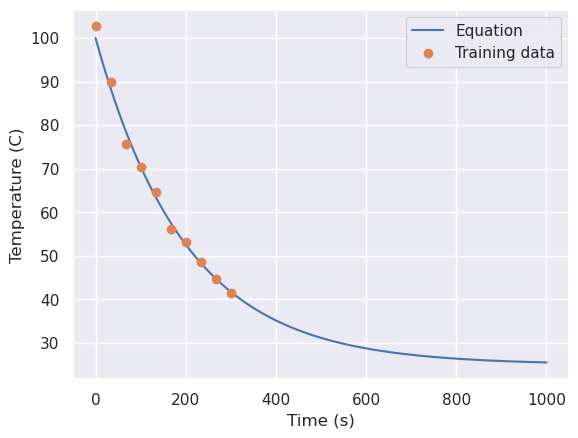

In [4]:
np.random.seed(10)

Tenv = 25
T0 = 100
R = 0.005
times = np.linspace(0, 1000, 1000)
eq = functools.partial(cooling_law, Tenv=Tenv, T0=T0, R=R)
temps = eq(times)

# Make training data
t = np.linspace(0, 300, 10)
T = eq(t) +  2 * np.random.randn(10)

plt.plot(times, temps)
plt.plot(t, T, 'o')
plt.legend(['Equation', 'Training data'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')


# Vanilla Networks

## 🔧 신경망 모델(Net, NetDiscovery) 코드 설명

이 코드는 **뉴턴 냉각 법칙(Newton’s Cooling Law)** 과 같은  
간단한 물리 시스템에서 **데이터 기반 신경망(NN)** 또는  
**물리 파라미터 추정(PINN-style parameter discovery)** 을 수행하기 위한 모델 구조입니다.

---

# 1️⃣ `np_to_th(x)`  
Numpy 배열을 GPU/CPU에 맞게 **PyTorch Tensor** 로 변환하는 유틸리티 함수입니다.

- 입력: numpy array `(N,)`  
- 출력: torch tensor `(N, 1)`  
- 자동으로 `DEVICE` 로 옮겨짐 (GPU 사용 가능)

---

# 2️⃣ `class Net(nn.Module)`  
일반적인 **다층 신경망(MLP)** 구조를 정의합니다.

### 🔹 주요 특징
- 입력 차원: `input_dim`  
- 출력 차원: `output_dim`  
- 은닉층 유닛 수: `n_units`  
- 4개의 ReLU 은닉층 + 출력층  
- 옵티마이저: Adam  
- 기본 손실: MSE

### 🔹 `fit()` 메서드  
- 훈련 루프 수행  
- 손실 기록  
- 필요 시 추가 손실(loss2) 적용  
  → PINN에서 물리 잔차(loss2) 추가할 때 사용 가능

### 🔹 `predict()`  
- 예측 결과를 numpy 로 반환

---

# 3️⃣ `class NetDiscovery(Net)`
`Net` 을 상속해서 만든 **파라미터 발견(Discovery)** 모델입니다.  
핵심은 내부에 **학습 가능한 물리 파라미터 R** 을 포함하는 것.

### 🔥 핵심 부분
```python
self.r = nn.Parameter(data=torch.tensor([0.]))
```

- `self.r`은 **신경망이 직접 학습하는 물리 파라미터**
- 예: 뉴턴 냉각 법칙에서  
  \[
  \frac{dT}{dt} = -R (T - T_{\text{env}})
  \]
  여기서 **R을 데이터로부터 학습**하게 됨.
- 초기값은 0으로 시작하지만 훈련 과정에서 실제 값으로 업데이트됨.

### 📌 PINN 구조에서 사용하는 방식
`loss2(self)` 내부에서 `self.r` 을 사용해 미분 방정식 잔차를 계산하면  
신경망은:

- (1) 데이터에 맞게 T(t)를 예측하고  
- (2) PDE 잔차가 최소가 되도록 R도 함께 조정  

즉, **물리 방정식 + 데이터 둘 다 만족하는 R을 자동으로 찾는 구조**가 됨.

---

# 🧠 요약

| 클래스 | 설명 |
|--------|-------|
| **Net** | 일반적인 회귀용 MLP, 데이터만 학습 |
| **NetDiscovery** | Net을 확장하여 **물리 파라미터(R)** 를 NN 내부에서 직접 학습 |

---

# 📘 이 구조의 장점

- 복잡한 PDE/ODE가 있어도 **데이터 + 물리 잔차**를 동시에 만족하도록 학습  
- **측정 불가능한 물리 상수(R)** 를 자동으로 추정  
- PINN 기반 Scientific Machine Learning(SciML)에서 자주 사용됨  



In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as thdat

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def np_to_th(x):
    n_samples = len(x)
    return torch.from_numpy(x).to(torch.float).to(DEVICE).reshape(n_samples, -1)


class Net(nn.Module):
    def __init__(
        self,
        input_dim,
        output_dim,
        n_units=100,
        epochs=1000,
        loss=nn.MSELoss(),
        lr=1e-3,
        loss2=None,
        loss2_weight=0.1,
    ) -> None:
        super().__init__()

        self.epochs = epochs
        self.loss = loss
        self.loss2 = loss2
        self.loss2_weight = loss2_weight
        self.lr = lr
        self.n_units = n_units

        self.layers = nn.Sequential(
            nn.Linear(input_dim, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
        )
        self.out = nn.Linear(self.n_units, output_dim)

    def forward(self, x):
        h = self.layers(x)
        out = self.out(h)

        return out

    def fit(self, X, y):
        Xt = np_to_th(X)
        yt = np_to_th(y)

        optimiser = optim.Adam(self.parameters(), lr=self.lr)
        self.train()
        losses = []
        for ep in range(self.epochs):
            optimiser.zero_grad()
            outputs = self.forward(Xt)
            loss = self.loss(yt, outputs)
            if self.loss2:
                loss += self.loss2_weight * self.loss2(self)
            loss.backward()
            optimiser.step()
            losses.append(loss.item())
            if ep % int(self.epochs / 10) == 0:
                print(f"Epoch {ep}/{self.epochs}, loss: {losses[-1]:.2f}")
        return losses

    def predict(self, X):
        self.eval()
        out = self.forward(np_to_th(X))
        return out.detach().cpu().numpy()


class NetDiscovery(Net):
    def __init__(
        self,
        input_dim,
        output_dim,
        n_units=100,
        epochs=1000,
        loss=nn.MSELoss(),
        lr=0.001,
        loss2=None,
        loss2_weight=0.1,
    ) -> None:
        super().__init__(
            input_dim, output_dim, n_units, epochs, loss, lr, loss2, loss2_weight
        )

        self.r = nn.Parameter(data=torch.tensor([0.]))


Epoch 0/20000, loss: 4713.88
Epoch 2000/20000, loss: 2509.90
Epoch 4000/20000, loss: 2141.75
Epoch 6000/20000, loss: 722.90
Epoch 8000/20000, loss: 87.94
Epoch 10000/20000, loss: 2.05
Epoch 12000/20000, loss: 0.43
Epoch 14000/20000, loss: 0.36
Epoch 16000/20000, loss: 0.35
Epoch 18000/20000, loss: 0.34


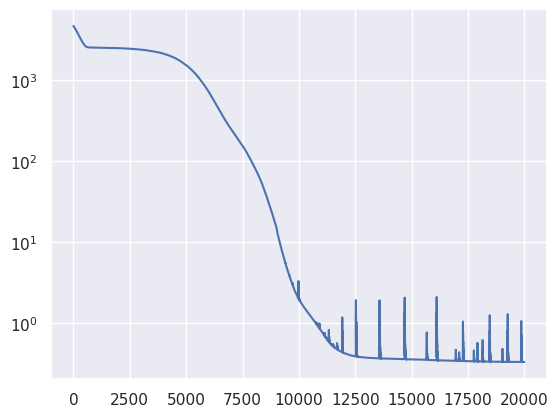

In [6]:
net = Net(1,1, loss2=None, epochs=20000, lr=1e-5).to(DEVICE)

losses = net.fit(t, T)

plt.plot(losses)
plt.yscale('log')

In [7]:
def l2_reg(model: torch.nn.Module):
    return torch.sum(sum([p.pow(2.) for p in model.parameters()]))

Text(0.5, 0, 'Time (s)')

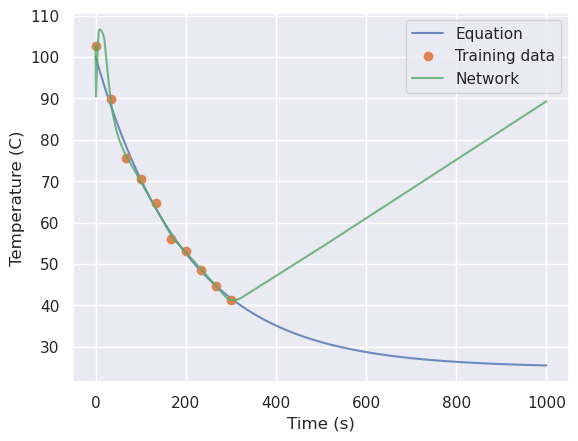

In [12]:


preds = net.predict(times)
plt.plot(times, temps, alpha=0.8)
plt.plot(t, T, 'o')
plt.plot(times, preds, alpha=0.8)

plt.legend(labels=['Equation','Training data', 'Network', 'L2 Network'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')


# PINN

In [13]:
def physics_loss(model: torch.nn.Module):
    ts = torch.linspace(0, 1000, steps=1000,).view(-1,1).requires_grad_(True).to(DEVICE)
    temps = model(ts)
    dT = grad(temps, ts)[0]
    pde = R*(Tenv - temps) - dT
    
    return torch.mean(pde**2)

In [ ]:
net = Net(1,1, loss2=physics_loss, epochs=20000, loss2_weight=1, lr=1e-5).to(DEVICE)

losses = net.fit(t, T)
plt.plot(losses)
plt.yscale('log')

Epoch 0/30000, loss: 4816.04


Text(0.5, 0, 'Time (s)')

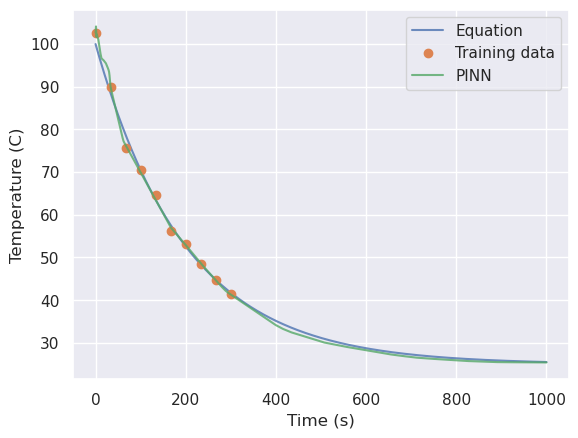

In [10]:
preds = net.predict(times)

plt.plot(times, temps, alpha=0.8)
plt.plot(t, T, 'o')
plt.plot(times, preds, alpha=0.8)
plt.legend(labels=['Equation','Training data', 'PINN'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')

# Parameter discovery

In [11]:
def physics_loss_discovery(model: torch.nn.Module):
    ts = torch.linspace(0, 1000, steps=1000,).view(-1,1).requires_grad_(True).to(DEVICE)
    temps = model(ts)
    dT = grad(temps, ts)[0]
    pde = model.r * (Tenv - temps) - dT
    
    return torch.mean(pde**2)

Epoch 0/40000, loss: 4816.01
Epoch 4000/40000, loss: 2501.51
Epoch 8000/40000, loss: 2075.70
Epoch 12000/40000, loss: 558.49
Epoch 16000/40000, loss: 3.97
Epoch 20000/40000, loss: 1.51
Epoch 24000/40000, loss: 1.06
Epoch 28000/40000, loss: 0.60
Epoch 32000/40000, loss: 0.40
Epoch 36000/40000, loss: 0.30


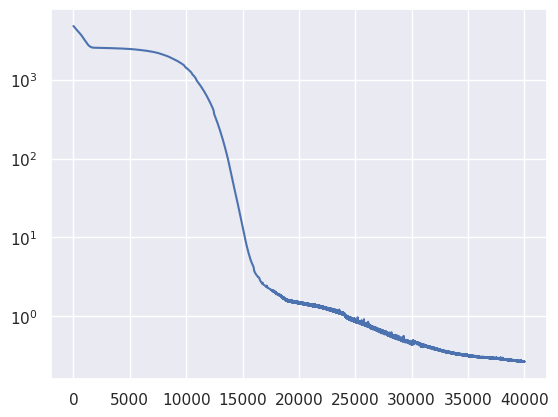

In [12]:
netdisc = NetDiscovery(1, 1, loss2=physics_loss_discovery, loss2_weight=1, epochs=40000, lr= 5e-6).to(DEVICE)

losses = netdisc.fit(t, T)
plt.plot(losses)
plt.yscale('log')

Parameter containing:
tensor([0.0052], device='cuda:0', requires_grad=True)


Text(0.5, 0, 'Time (s)')

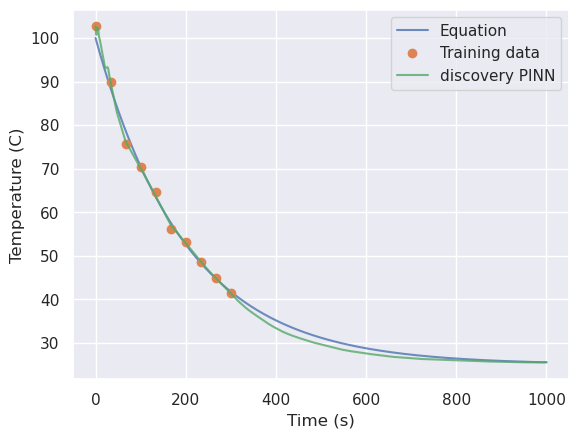

In [13]:
preds = netdisc.predict(times)
print(netdisc.r)

plt.plot(times, temps, alpha=0.8)
plt.plot(t, T, 'o')
plt.plot(times, preds, alpha=0.8)
plt.legend(labels=['Equation','Training data', 'discovery PINN'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')